# Predicting Box Office Revenue

In [288]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.stats import zscore

### Data cleanup

Join to two dataset files by movie id, and drop duplicate columns.

In [289]:
movies_data = pd.read_csv('../tmdb_5000_movies.csv')
credits_data = pd.read_csv('../tmdb_5000_credits.csv')

# Perform an inner join on the movies and credits data so it's all in one dataframe
all_movies_data = pd.merge(movies_data, credits_data, left_on='id', right_on='movie_id', how='inner', suffixes=('_movies', '_credits'))

# Drop duplicate id and title fields
all_movies_data = all_movies_data.drop(columns=['movie_id', 'title_credits'])
# Rename original title field
all_movies_data = all_movies_data.rename(columns={'title_movies': 'title'})

print('Movies remaining in dataset after merge: {}'.format(len(all_movies_data)))

Movies remaining in dataset after merge: 4803


Drop rows with no budget or revenue data, since that's what we want to analyze. 

In [290]:
# Remove data with no revenue or budget info
all_movies_data = all_movies_data[all_movies_data['budget'] > 0]
all_movies_data = all_movies_data[all_movies_data['revenue'] > 0]

print('Movies remaining in dataset after dropping rows without budget or revenue data: {}'.format(len(all_movies_data)))

Movies remaining in dataset after dropping rows without budget or revenue data: 3229


Remove upper bound revenue outliers, otherwise every result looks just suggests "Make an action movie with James Cameron".

In [291]:
all_movies_data['revenue_zscore'] = zscore(all_movies_data['revenue'])
all_movies_data = all_movies_data[all_movies_data['revenue_zscore'] <= 2]
print('Movies remaining in dataset after removing upper revenue outliers: {}'.format(len(all_movies_data)))

Movies remaining in dataset after removing upper revenue outliers: 3079


Convert the genre field from a string to a list of dictionaries. Drop rows that cannot be formatted, or contain an empty list of genres.

In [292]:
def format_genres(genre_list):
    try:
        return json.loads(genre_list)
    except (ValueError, SyntaxError, TypeError):
        return np.nan

# Avoiding in-place modification here so the cells run smoothly
all_movies_data['formatted_genres'] = all_movies_data['genres'].apply(format_genres)
# Drop rows that cannot be formatted
all_movies_data = all_movies_data[all_movies_data['formatted_genres'] != np.nan]
# Drop rows that contain an empty genre list
all_movies_data = all_movies_data[all_movies_data['formatted_genres'].apply(lambda x: len(x) > 0)]

print('Formatted genre field example: {}'.format(all_movies_data.iloc[0]['formatted_genres']))
print('Movies remaining in dataset after formatting genres: {}'.format(len(all_movies_data)))

Formatted genre field example: [{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 878, 'name': 'Science Fiction'}]
Movies remaining in dataset after formatting genres: 3078


Create a `primary_genre` column for easier access later.

In [293]:
# Create primary_genre column using the first genre in the genre list
all_movies_data['primary_genre'] = all_movies_data['formatted_genres'].apply(lambda x: x[0]['name'])
print('Primary genre field example: {}'.format(all_movies_data.iloc[0]['primary_genre']))

Primary genre field example: Action


Create `profit` and `profit_ratio` columns.

In [294]:
all_movies_data['profit_ratio'] = all_movies_data['revenue'] / all_movies_data['budget']
all_movies_data['profit'] = all_movies_data['revenue'] - all_movies_data['budget']
print('profit_ratio field example: {}'.format(all_movies_data.iloc[0]['profit_ratio']))
print('profit field example: {}'.format(all_movies_data.iloc[0]['profit']))

profit_ratio field example: 1.0928426923076924
profit field example: 24139100


### Descriptive Statistics

#### Revenue - general descriptive statistics

In [295]:
all_movies_revenue = all_movies_data['revenue']
mean_all_movies_revenue = np.mean(all_movies_revenue)
median_all_movies_revenue = np.median(all_movies_revenue)
std_all_movies_revenue = np.std(all_movies_revenue)

all_movies_data[['revenue']].describe().style.format("{:,.2f}")

,revenue
count,"3,078.00"
mean,"89,295,019.00"
std,"101,934,968.14"
min,5.00
25%,"15,807,293.75"
50%,"50,408,342.00"
75%,"124,867,625.50"
max,"491,868,548.00"


#### Budget - general descriptive statistics

In [296]:
all_movies_budget = all_movies_data['budget']
mean_all_movies_revenue = np.mean(all_movies_budget)
median_all_movies_revenue = np.median(all_movies_budget)
std_all_movies_revenue = np.std(all_movies_budget)

all_movies_data[['budget']].describe().style.format("{:,.2f}")

,budget
count,"3,078.00"
mean,"35,622,661.53"
std,"36,251,388.57"
min,1.00
25%,"10,000,000.00"
50%,"25,000,000.00"
75%,"50,000,000.00"
max,"270,000,000.00"


#### Revenue:Budget Profit Ratio - general descriptive statistics

In [297]:
all_movies_data['profit_ratio'] = all_movies_data['revenue'] / all_movies_data['budget']

all_movies_profit_ratio = all_movies_data['profit_ratio']
mean_all_movies_revenue = np.mean(all_movies_profit_ratio)
median_all_movies_revenue = np.median(all_movies_profit_ratio)
std_all_movies_revenue = np.std(all_movies_profit_ratio)

all_movies_data[['profit_ratio']].describe().style.format("{:,.2f}")

,profit_ratio
count,"3,078.00"
mean,"3,099.41"
std,"154,259.89"
min,0.00
25%,0.97
50%,2.18
75%,4.18
max,"8,500,000.00"


Scatter plot of Budget vs Revenue by Primary genre

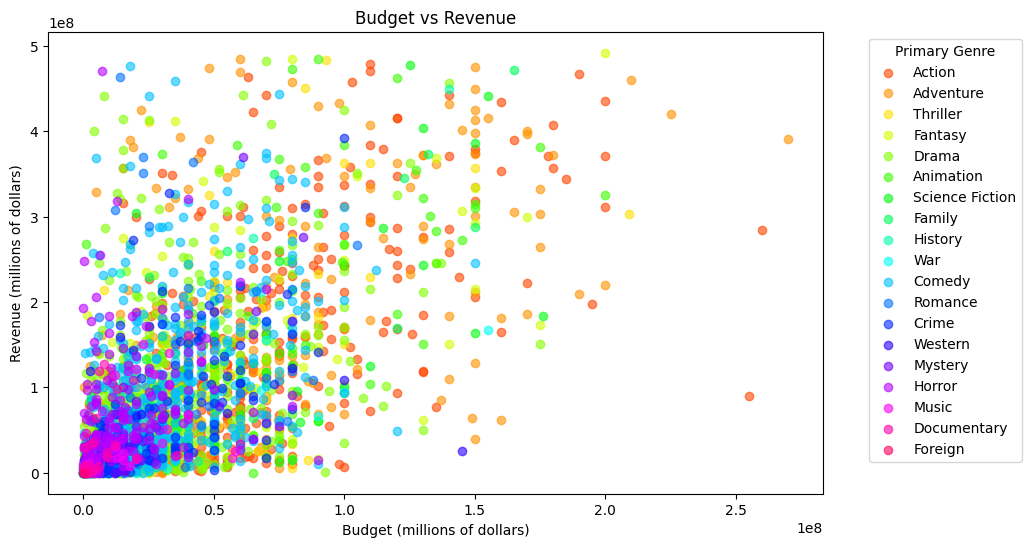

In [298]:
# Create a color palette
unique_genres = all_movies_data['primary_genre'].unique()
genre_palette = sns.color_palette('hsv', len(unique_genres))
genre_color_map = dict(zip(unique_genres, genre_palette))

# Create a scatter plot of budget vs revenue by genre
plt.figure(figsize=(10, 6))
for genre in unique_genres:
    subset = all_movies_data[all_movies_data['primary_genre'] == genre]
    plt.scatter(subset['budget'], subset['revenue'], label=genre, color=genre_color_map[genre], alpha=0.6)
plt.title('Budget vs Revenue')
plt.xlabel('Budget (millions of dollars)')
plt.ylabel('Revenue (millions of dollars)')
plt.legend(title='Primary Genre', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Side-by-side box plots of profit and profit_ratio by genre

/var/folders/q4/_1_vts6n2vg5rvqrn52fvfd00000gn/T/ipykernel_81826/849915154.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='primary_genre', y='profit', data=all_movies_data, palette=genre_color_map)


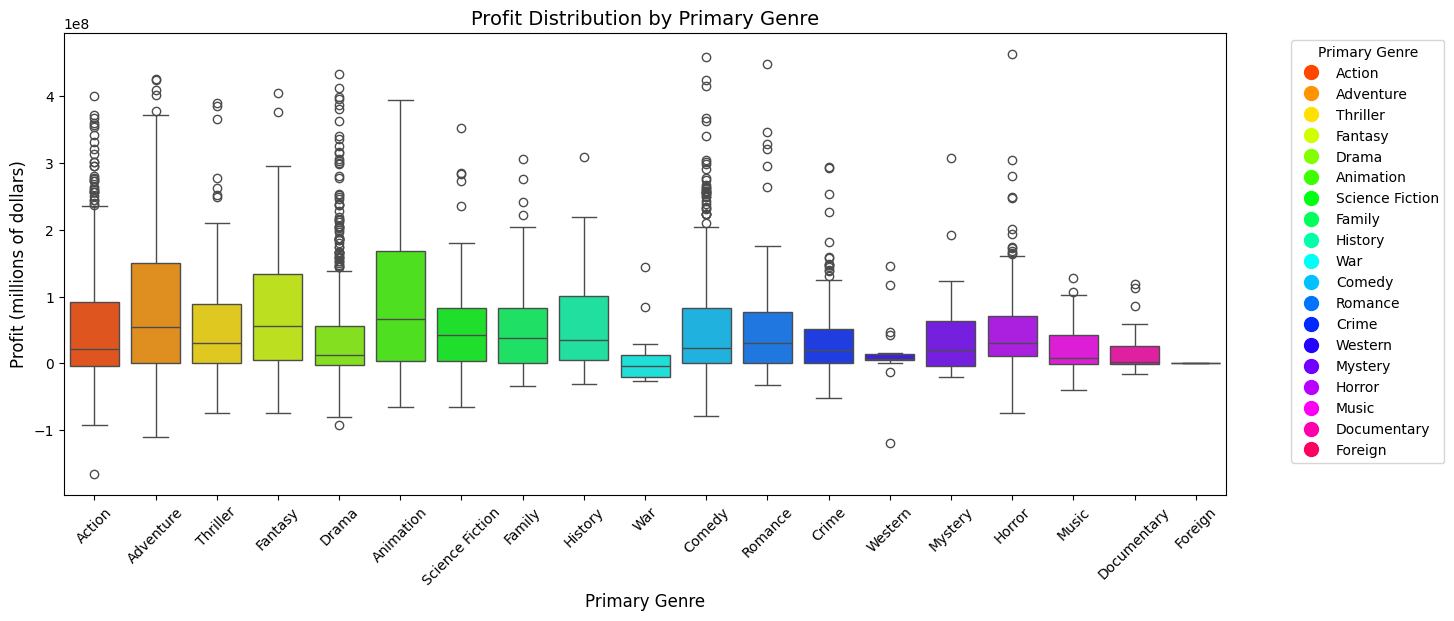

In [299]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='primary_genre', y='profit', data=all_movies_data, palette=genre_color_map)

plt.title('Profit Distribution by Primary Genre', fontsize=14)
plt.xlabel('Primary Genre', fontsize=12)
plt.ylabel('Profit (millions of dollars)', fontsize=12)
handles = [plt.Line2D([0], [0], color=genre_color_map[genre], marker='o', linestyle='', markersize=10) for genre in unique_genres]
plt.legend(handles, unique_genres, title='Primary Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

plt.show()